# Classify whether patient is a heart disease candidate using random forest in Python
------------
This work is part of a collection of practice sets called [Machine Learning Starter](https://github.com/jamiemorales/project-machine-learning-starter).
It aims to help someone get started fast and gain a high-level understanding of the fundamental steps in the machine learning lifecycle early on.
After completion, someone will have built intuition over the machine learning lifecycle. 

## Step 0: Understand the problem
What we're trying to do here is to classify whether a patient has heart disease.

## Step 1: Set-up and understand data
This step helps uncover issues that we will want to address in the next step and take into account when building and evaluating our model. We also want to find interesting relationships or patterns that we can possibly leverage in solving the problem we specified.

In [3]:
# Set-up libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [4]:
# Read-in data
df = pd.read_csv('../00-Datasets/heart.csv')

In [4]:
# Look at some records
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
# Look at some records
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
# Check for missing values
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [7]:
# Check for duplicate values
df.duplicated().sum()

1

It turns out we have duplicated record(s). Let's see which record(s).

In [12]:
df[df.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


1    165
0    138
Name: target, dtype: int64

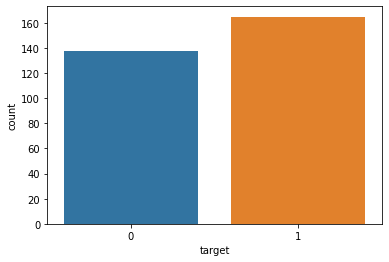

In [15]:
# Look at breakdown of label
sns.countplot(df['target'])
df['target'].value_counts()

In [16]:
# Explore correlations to label
df.corr()['target'].sort_values(ascending=False)

target      1.000000
cp          0.433798
thalach     0.421741
slope       0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex        -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang      -0.436757
Name: target, dtype: float64

In [17]:
# Summarise
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Step 2: Preprocess data and understand some more
This step typically takes the most time in the cycle but for our purposes, most of the datasets chosen in this series are clean.

Real-world datasets are noisy and incomplete. The choices we make in this step to address data issues can impact downstream steps and the result itself. For example, it can be tricky to address missing data when we don't know why it's missing. Is it missing completely at random or not? It can also be tricky to address outliers if we do not understand the domain and problem context enough.

First, recall that we found duplicate values in the previous step. Let's see the records.

In [19]:
# Show duplicated
df[df.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


It looks like it's reasonable to assume that it's safe to keep one and remove the other.

In [20]:
# Remove duplicate
df.drop_duplicates(keep='first', inplace=True)

In [21]:
# Show duplicated
df[df.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target


In [22]:
# Show remaining record
df.iloc[163]

age          38.0
sex           1.0
cp            2.0
trestbps    138.0
chol        175.0
fbs           0.0
restecg       1.0
thalach     173.0
exang         0.0
oldpeak       0.0
slope         2.0
ca            4.0
thal          2.0
target        1.0
Name: 163, dtype: float64

Above, we have the remaining and now unique record.

In [23]:
# Split data into test and validation
X = df.drop('target', axis=1)
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

## Step 3: Model and evaluate
This last step is three-fold.

We create the model and fit the model to the data we prepared for training.

We then proceed to classifying with the data we prepared for validation.

Lastly, we evaluate the model's performance with mainstream classification metrics.

In [26]:
# Build model and train
model = RandomForestClassifier().fit(X_train, y_train)

In [27]:
# Apply model to validation data
y_predict = model.predict(X_val)

In [28]:
# Compare actual and predicted values
actual_vs_predict = pd.DataFrame({'Actual': y_val,
                                'Prediction': y_predict})
actual_vs_predict.sample(12)

,Actual,Prediction
26,1,1
219,0,0
52,1,0
108,1,1
124,1,1
146,1,1
169,0,0
157,1,1
189,0,1
34,1,1


In [30]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_predict))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.86      0.93      0.89        27
           1       0.94      0.88      0.91        34

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



## More

If you found this work interesting, you might like:

* Machine Learning Starter

* Deep Learning Starter

* Natural Language Processing Starter

You can find more at [github.com/jamiemorales](https://github.com/jamiemorales).

Datasets are not mine. List of sources: [datasets and sources](https://github.com/jamiemorales/project-machine-learning-starter/blob/master/00-Datasets/Data%20sources.txt)

For sharing this work, here's how / the license: https://creativecommons.org/licenses/by-sa/4.0/